In [1]:
import pandas as pd
import matplotlib

from preprocessing.cleaner import IndonesianNewsCleaner, CleanerPipeline
from preprocessing.combiner import TextCombiner
from preprocessing.deduplicater import drop_duplicates_normalized

from sklearn.model_selection import train_test_split

from news_classification.models.model import HierarchicalSVMModel
from news_classification.bundler import save_bundle, load_bundle

from pathlib import Path

In [ ]:
df = pd.read_csv("data/news_with_topics.csv")

In [3]:
df.head()

,Judul,Waktu,Link,Content,tag1,tag2,tag3,tag4,tag5,source,topic
0,"Toko Emas Palsu di Riau Dibongkar Polisi, Perh...","Rabu, 30 Jul 2025 22:22 WIB",https://news.detik.com/melindungi-tuah-marwah/...,Satreskrim Polres Bengkalis membongkar praktik...,pemalsuan emas,emas palsu,polres bengkalis,polda riau,melindungi tuah marwah,detik,Kejahatan Finansial
1,Hasil Liga 1: Duel Arema FC vs PSM Makassar Be...,10 Februari 2025 | 17.48 WIB,https://www.tempo.co/sepakbola/hasil-liga-1-du...,"Baca berita dengan sedikit iklan, klik di sin...",liga-1,arema-fc,psm-makassar,arema-fc-vs-psm-makassar,hasil-liga-1,tempo,Sepak Bola
2,Warga Sebut Mobil Nyangkut di Separator Margon...,"Senin, 12 Agu 2024 22:04 WIB",https://news.detik.com/berita/d-7486696/warga-...,Mobil mengalami kecelakaan hingga tersangkut d...,depok,jabodetabek,tabrakan,NaN,NaN,detik,Kecelakaan Lalu Lintas
3,Jaksa Agung ST Burhanuddin Bantah Isu Mundur,5 Juni 2025,https://nasional.kompas.com/read/2025/06/05/18...,"JAKARTA, KOMPAS.com - Jaksa Agung Sanitiar (S...",Jaksa Agung,ST Burhanuddin,jaksa agung mundur,jaksa agung bantah mundur,NaN,kompas,Menteri Keuangan
4,Kemacetan Jakarta Disebut Jadi PR Besar Gubern...,3 September 2024,https://megapolitan.kompas.com/read/2024/09/03...,"JAKARTA, KOMPAS.com - Analis Kebijakan Transp...",jakarta macet,Penyebab Jakarta macet,Pilkada Jakarta 2024,NaN,NaN,kompas,Kemacetan Lalu Lintas


In [4]:
TAG_COLS = [c for c in df.columns if c.startswith("tag")]

combiner = TextCombiner(
    text_cols=["Judul", "Content", *TAG_COLS],
    sep=" "
)

df = combiner.combine_df(df, out_col="text")
df = df[df["text"].str.len() > 0].copy()

In [5]:
df[["text", "topic"]]

,text,topic
0,"Toko Emas Palsu di Riau Dibongkar Polisi, Perh...",Kejahatan Finansial
1,Hasil Liga 1: Duel Arema FC vs PSM Makassar Be...,Sepak Bola
2,Warga Sebut Mobil Nyangkut di Separator Margon...,Kecelakaan Lalu Lintas
3,Jaksa Agung ST Burhanuddin Bantah Isu Mundur J...,Menteri Keuangan
4,Kemacetan Jakarta Disebut Jadi PR Besar Gubern...,Kemacetan Lalu Lintas
...,...,...
8010,BMKG: Cuaca Ekstrem Berpotensi Terjadi hingga ...,Iklim & Cuaca
8011,"Jelang APEC, PM Korea Selatan Kecam Aksi Anti-...",Pemakzulan Presiden Korsel
8012,Patrick Kluivert: Adopsi Sistem Baru Berhasil ...,Sepak Bola
8013,Pernyataan Kontroversial Sri Mulyani Sebelum D...,Menteri Keuangan


<Axes: xlabel='topic', ylabel='%'>

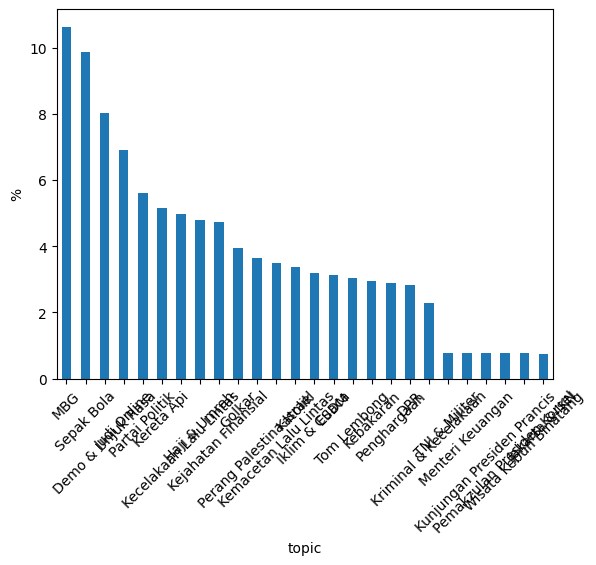

In [6]:
df[df["topic"].notna()]["topic"].value_counts(normalize=True).mul(100).sort_values(ascending=False).plot(kind="bar", rot=45, ylabel="%")

In [7]:
df = drop_duplicates_normalized(df, subset=["text"], normalize_fn=IndonesianNewsCleaner.clean)

In [8]:
X = df["text"].astype(str).tolist()
y = df["topic"].astype(str).tolist()

In [9]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=1/9, random_state=42, stratify=y_trainval)

In [10]:
print(len(X_train), len(X_val), len(X_test))

5572 697 697


In [11]:
print("Overlap between train and val:", len(set(X_train) & set(X_val)))
print("Overlap between train and val:", len(set(X_train) & set(X_test)))
print("Overlap between val and test:", len(set(X_val) & set(X_test)))

Overlap between train and val: 0
Overlap between train and val: 0
Overlap between val and test: 0


In [12]:
clean_fn = CleanerPipeline([IndonesianNewsCleaner])
model = HierarchicalSVMModel(
    clean_fn=clean_fn,
    optuna_trials=25,
    optuna_timeout_sec=600
)

In [13]:
model.fit(X_train, y_train, X_val_text=X_val, y_val=y_val, tune=True, refit_on_train_val=True)

val_metrics = model.evaluate(X_val, y_val)
test_metrics = model.evaluate(X_test, y_test)

print("VAL macro_f1:", val_metrics["macro_f1"])
print("TEST macro_f1:", test_metrics["macro_f1"])

[I 2026-01-01 22:26:01,738] A new study created in memory with name: no-name-f3f65499-0492-4a0a-812a-740d1ee548af
[I 2026-01-01 22:26:26,799] Trial 0 finished with value: 0.9682578619482748 and parameters: {'ngram_max': 3, 'min_df': 5, 'max_df': 0.8626718700235674, 'word_max_features': 300000, 'char_max_features': 60000, 'C': 3.9375207308629543}. Best is trial 0 with value: 0.9682578619482748.
[I 2026-01-01 22:26:47,753] Trial 1 finished with value: 0.9706630269436709 and parameters: {'ngram_max': 2, 'min_df': 2, 'max_df': 0.9591492996429988, 'word_max_features': 300000, 'char_max_features': 180000, 'C': 1.7966150815710624}. Best is trial 1 with value: 0.9706630269436709.
[I 2026-01-01 22:27:08,528] Trial 2 finished with value: 0.9694560005114294 and parameters: {'ngram_max': 2, 'min_df': 2, 'max_df': 0.9009673178731572, 'word_max_features': 190000, 'char_max_features': 100000, 'C': 4.372044609712126}. Best is trial 1 with value: 0.9706630269436709.
[I 2026-01-01 22:27:23,586] Trial 3 

VAL macro_f1: 1.0
TEST macro_f1: 0.9684619893983675


In [14]:
res = model.evaluate(X_test, y_test)

display(res["report_df"])
display(res["confusion_df"])
display(res["top_confusions_df"])
print(res["report_text"])

,precision,recall,f1-score,support
DPR,1.000000,0.950000,0.974359,20.000000
Demo & Unjuk Rasa,0.933333,0.965517,0.949153,58.000000
ESDM,0.960000,1.000000,0.979592,24.000000
Golkar,1.000000,0.960000,0.979592,25.000000
Haji & Umrah,0.970588,1.000000,0.985075,33.000000
Iklim & Cuaca,1.000000,0.960000,0.979592,25.000000
Jakarta & IKN,1.000000,0.750000,0.857143,4.000000
Judi Online,1.000000,0.957447,0.978261,47.000000
Katolik,1.000000,0.960000,0.979592,25.000000
Kebakaran,0.947368,0.947368,0.947368,19.000000


,DPR,Demo & Unjuk Rasa,ESDM,Golkar,Haji & Umrah,Iklim & Cuaca,Jakarta & IKN,Judi Online,Katolik,Kebakaran,...,MBG,Menteri Keuangan,Partai Politik,Pemakzulan Presiden Korsel,Penghargaan,Perang Palestina-Israel,Sepak Bola,TNI & Militer,Tom Lembong,Wisata Kebun Binatang
DPR,19,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Demo & Unjuk Rasa,0,56,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ESDM,0,0,24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Golkar,0,0,0,24,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Haji & Umrah,0,0,0,0,33,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Iklim & Cuaca,0,1,0,0,0,24,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Jakarta & IKN,0,0,0,0,1,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Judi Online,0,0,0,0,0,0,0,45,0,0,...,0,0,0,0,1,0,0,0,0,0
Katolik,0,1,0,0,0,0,0,0,24,0,...,0,0,0,0,0,0,0,0,0,0
Kebakaran,0,0,1,0,0,0,0,0,0,18,...,0,0,0,0,0,0,0,0,0,0


,true,pred,count
0,MBG,Penghargaan,2
1,Kecelakaan Lalu Lintas,Kejahatan Finansial,1
2,Judi Online,Kejahatan Finansial,1
3,Kecelakaan Lalu Lintas,Penghargaan,1
4,Demo & Unjuk Rasa,Kebakaran,1
5,Kebakaran,ESDM,1
6,Demo & Unjuk Rasa,Kemacetan Lalu Lintas,1
7,Golkar,Perang Palestina-Israel,1
8,Jakarta & IKN,Haji & Umrah,1
9,Judi Online,Penghargaan,1


                            precision    recall  f1-score   support

                       DPR       1.00      0.95      0.97        20
         Demo & Unjuk Rasa       0.93      0.97      0.95        58
                      ESDM       0.96      1.00      0.98        24
                    Golkar       1.00      0.96      0.98        25
              Haji & Umrah       0.97      1.00      0.99        33
             Iklim & Cuaca       1.00      0.96      0.98        25
             Jakarta & IKN       1.00      0.75      0.86         4
               Judi Online       1.00      0.96      0.98        47
                   Katolik       1.00      0.96      0.98        25
                 Kebakaran       0.95      0.95      0.95        19
    Kecelakaan Lalu Lintas       1.00      0.93      0.96        29
       Kejahatan Finansial       0.91      0.97      0.94        31
     Kemacetan Lalu Lintas       0.92      1.00      0.96        22
                Kereta Api       0.97      0.97

In [15]:
out_dir = Path("artifacts/indo_news_v1")

state = model.get_state()

cleaner_meta = {
    "cleaning": {
        "pipeline": ["IndonesianNewsCleaner"],
        "module": "news_classification.preprocessing.cleaner",
    }
}

save_bundle(
    "artifacts/indo_news_v1",
    preprocessor=model.preprocessor_,
    clf=model.clf_,
    le=model.le_,
    le_aggregate=model.le_aggregate_,
    aggregate_map=model.aggregate_map_,
    best_params=model.best_params,
    val_macro_f1=model.val_macro_f1,
    test_macro_f1=test_metrics["macro_f1"],
    dataset="sh1zuka/indonesia-news-dataset-2024",
    text_columns=("Judul", "Content", "tag1", "tag2", "tag3", "tag4", "tag5"),
    label_column="topic",
    extra_meta=cleaner_meta
)

(WindowsPath('artifacts/indo_news_v1/bundle.joblib'),
 WindowsPath('artifacts/indo_news_v1/meta.json'))

In [16]:
payload = load_bundle(out_dir)

clean_fn = CleanerPipeline((IndonesianNewsCleaner,))
model2 = HierarchicalSVMModel(clean_fn=clean_fn).from_state(payload)

In [17]:
model2.predict(["Tangkap 74 Orang Terlibat Judi Online, Polda Sumut Ajukan Blokir 3.360 Situs ke Komdigi."])

array(['Judi Online'], dtype=object)